In [1]:
import os
os.chdir("/Users/davidamat/Documents/Projects/deepsetstats")
from importlib import reload

In [1113]:
from deepsetstats.utils import utils_tools
from deepsetstats.utils import constants as c
from deepsetstats.utils import videocapture as vc

In [1133]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import copy
import torch
import time

In [1135]:
utils_tools = reload(utils_tools)
c = reload(c)
vc = reload(vc)

In [1136]:
# Dictionary of vids
extension = ".mp4"
gs = [
    "wb",
    "rg",
    "ao",
    "us"
]
d_path_vids = {vid: str(Path(c.PATH_VIDS) / (vid + extension)) for vid in gs }

# 1. Explore frames

In [1139]:
VC = vc.VideoClass(d_path_vids["wb"])
vc_wb = vc.VideoClass(d_path_vids["wb"])
vc_ao = vc.VideoClass(d_path_vids["ao"])
vc_us = vc.VideoClass(d_path_vids["us"])
vc_rg = vc.VideoClass(d_path_vids["rg"])

In [1140]:
d_vc = {
    "wb": vc_wb,
    "rg": vc_rg,
    "ao": vc_ao,
    "us": vc_us
}

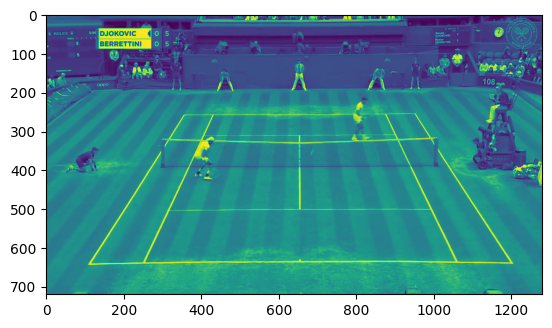

In [1141]:
# Wimbledon
f_wb = vc_wb.get_frame(29*25)
fg_wb = VC._correct_color(f_wb, gray=True)
VC.show_frame(fg_wb)

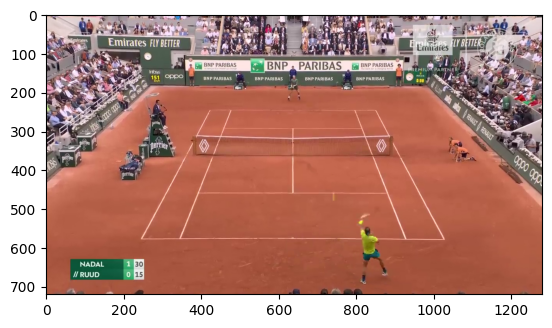

In [1012]:
# RG
f_rg = vc_rg.get_frame(29*25)
fg_rg = vc_rg._correct_color(f_rg, gray=True)
VC.show_frame(f_rg)

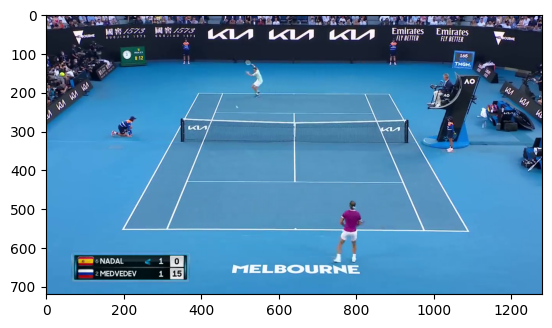

In [1013]:
# RG
f_ao = vc_ao.get_frame(29*25)
fg_ao = vc_ao._correct_color(f_ao, gray=True)
VC.show_frame(f_ao)

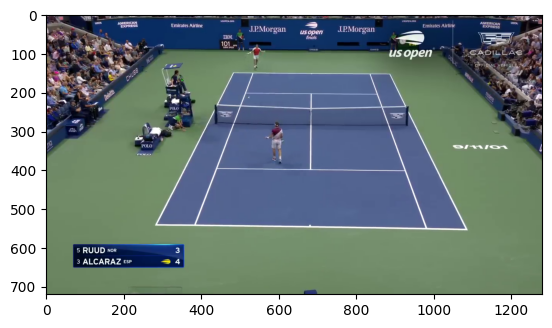

In [1014]:
# US
f_us = vc_us.get_frame(25*25)
fg_us = vc_us._correct_color(f_us, gray=True)
VC.show_frame(f_us)

In [1015]:
d_f = {
    "ao": f_ao,
    "us": f_us,
    "rg": f_rg,
    "wb": f_wb
}

d_fg = {
    "ao": fg_ao,
    "us": fg_us,
    "rg": fg_rg,
    "wb": fg_wb
}

## 1.1 Merging frames

In [1016]:
second = 160
f1 = VC.get_frame_second(second)
f2 = VC.get_frame_second(second + 0.2)
f3 = VC.get_frame_second(second + 0.4)
f4 = VC.get_frame_second(second + 0.6)

In [1017]:
fm = np.mean([f1,f2,f3,f4], axis=0, dtype=int)

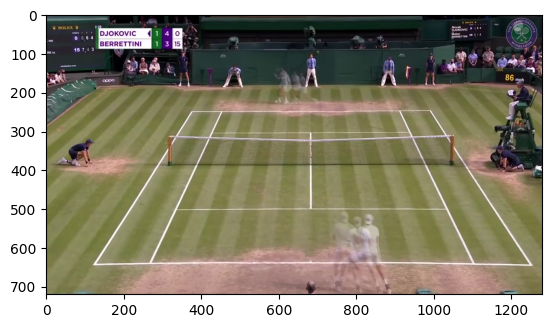

In [1018]:
VC.show_frame(fm)

# 2. Court Detection

In [1143]:
# Court type
rgb_court, court_type = vc_rg.detect_court(d_f["rg"])
print(f"Court Type: {court_type}")
print(f"Court RGB Colors: {c.D_GRAD_LINES[court_type]}")

Court Type: CLAY
Court RGB Colors: {'COURT': array([183, 115,  84]), 'LINE_CLEAN': array([234, 177, 153]), 'LINE_DIRTY': array([204, 140, 112])}


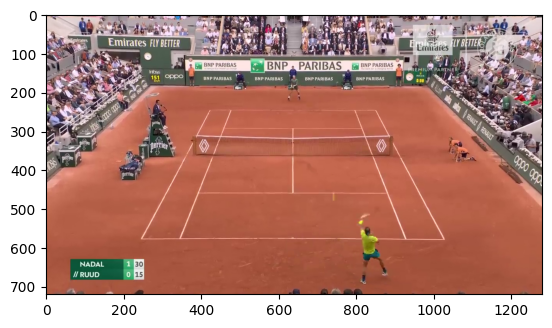

In [1144]:
VC.show_frame(d_f["rg"])

In [1035]:
slices = 8
width_sliced = width // slices
height_sliced = height // slices
slice_factor = (slices-1)/slices
width_slice_end = int(slice_factor * width)
height_slice_end = int(slice_factor * height)

In [1145]:
mask_lines = VC.get_line_mask(d_f["rg"], court_type)

TypeError: get_line_mask() missing 1 required positional argument: 'court_type'

In [1036]:
# ------------------------------------- #

# ------------------------------------- #
#     White filtering
# ------------------------------------- #

# ------------------------------------- #
d_neg = {}
do_slicing = False
for granslam in gs:
    fg_sliced = d_fg[granslam].copy()
    
    # Slice
    if do_slicing:
        fg_sliced = fg_sliced[height_sliced:, width_sliced:width_slice_end].copy()
    
    # Apply negative mask
    fg_sliced[fg_sliced < 200] = 0
    d_neg[granslam] = fg_sliced

In [ ]:
def get_line_mask(img, court_type):
    # ------------------------- #
    #     Line Tolerance
    # ------------------------- #
    RGB_LINE_DIRTY_TOL = c.D_GRAD_LINES[court_type]['LINE_DIRTY'] - c.TOL_LINE
    
    # ------------------------- #
    #     Get Mask
    # ------------------------- #
    #set the lower and upper bounds for the green hue
    lower_white = RGB_LINE_DIRTY_TOL
    upper_white = np.array([255,255,255])

    #create a mask for green colour using inRange function
    mask = cv2.inRange(img, lower_white, upper_white)
    return mask

In [1119]:
# Lines detect in RG
f_sliced = d_f["rg"].copy()

In [1120]:
f_sliced.shape

(720, 1280, 3)

In [1124]:
RGB_LINE_DIRTY = c.D_GRAD_LINES[court_type]['LINE_DIRTY']
tol_line = np.array([15, 10, 10])
RGB_LINE_DIRTY_TOL = RGB_LINE_DIRTY - tol_line

In [1132]:
%%time
#set the lower and upper bounds for the green hue
lower_white = RGB_LINE_DIRTY_TOL
upper_white = np.array([255,255,255])

#create a mask for green colour using inRange function
mask = cv2.inRange(f_sliced, lower_white, upper_white)

#perform bitwise and on the original image arrays using the mask
#res = cv.bitwise_and(f_sliced, f_sliced, mask=mask)

CPU times: user 1.46 ms, sys: 484 µs, total: 1.95 ms
Wall time: 868 µs


In [1131]:
np.unique(mask)

array([  0, 255], dtype=uint8)

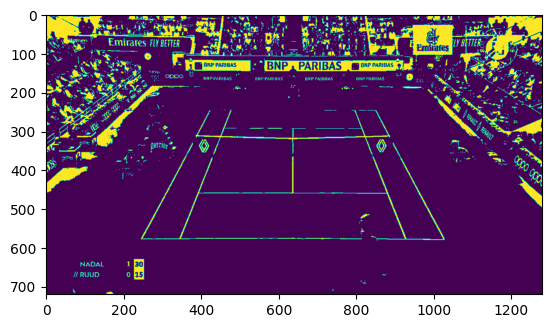

In [1126]:
VC.show_frame(mask)

In [ ]:
bitwise_and

error: OpenCV(4.6.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/thresh.cpp:1674: error: (-215:Assertion failed) src.type() == CV_8UC1 in function 'adaptiveThreshold'


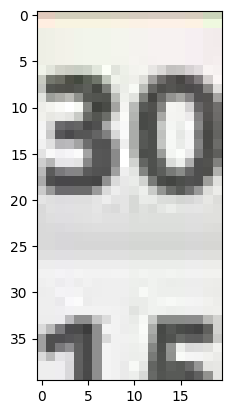

In [1078]:
VC.show_frame(f_sliced[630:670,230:250])

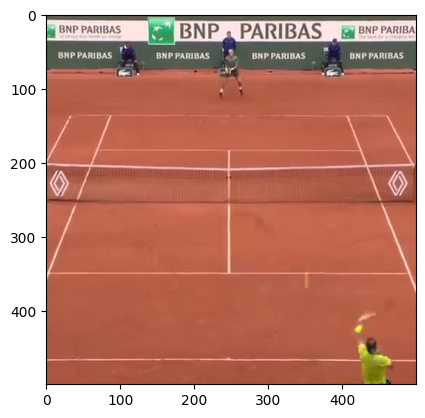

In [961]:
VC.show_frame(crop_img)

array([188.,  99.,  76.])

In [953]:
kmeans_img = np.reshape(crop_img, (-1,3))
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv2.KMEANS_RANDOM_CENTERS
compactness,labels,centers = cv2.kmeans(crop_img,1,None,criteria,10,flags)

print('Dominant color is: bgr({})'.format(centers[0].astype(np.int32)))

error: OpenCV(4.6.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/core/src/kmeans.cpp:242: error: (-215:Assertion failed) data0.dims <= 2 && type == CV_32F && K > 0 in function 'kmeans'


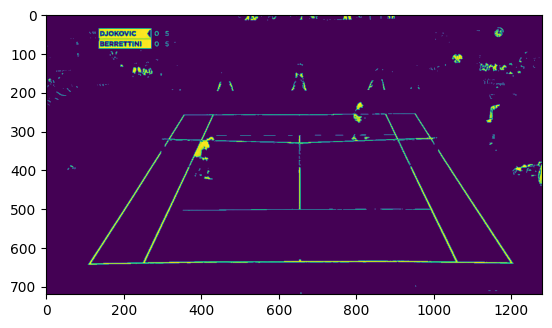

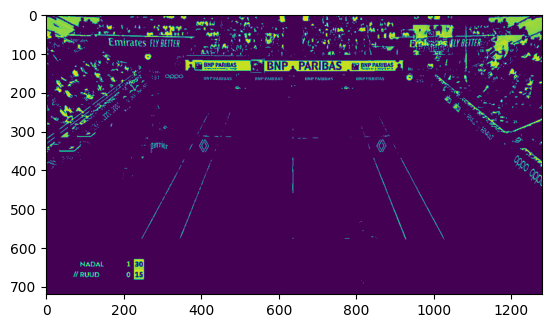

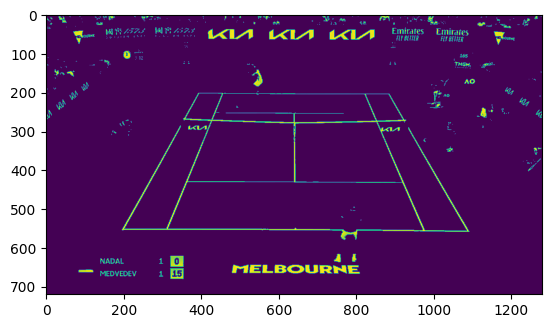

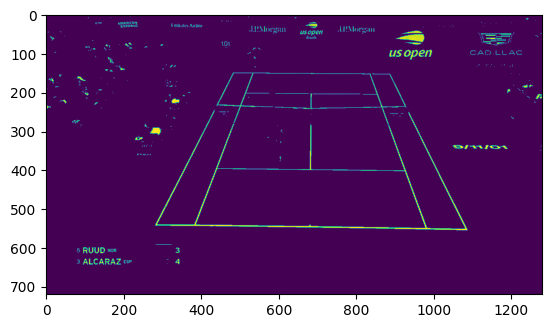

In [891]:
for igs in gs:
    VC.show_frame(d_neg[igs])

## 2.1 Trapezoidal Approach

In [892]:
class CourtTrapezoid:
    def __init__(self, vc):
        # X: first coordinate, corresponds to width
        # initialize pA to be in the bottom left corner (max height)
        self.vc = vc
        self.pA = (0, self.vc.h)
        self.add = lambda x,y: (int(x[0]+y[0]), int(x[1]+y[1]))
        self.flip = lambda tup: (tup[1], tup[0])
        self.white = (255, 255, 255)
        
    def generate_trapezoid_points(self,a,b,f,sc=1):
        a = int(a*sc)
        b = int(b*sc)
        f = int(f*sc)
        e = (a-b)//2
        pA = self.pA
        pB = self.add(pA, (e,-f))
        pC = self.add(pB, (b,0))
        pD = self.add(pA, (a,0))
        return np.array([pA, pB, pC, pD])
    
    def create_trapezoid(self, a, b, f, sc=1, stride=(0,0), thickness=15, img_input=None):
        pts = self.generate_trapezoid_points(a,b,f,sc)
        strided_pts = np.array([pts]) + np.array([stride])
        
        # Take the two images 
        img_trapezoid = np.zeros((self.vc.h, self.vc.w), np.uint8)
        if img_input is not None:
            img = copy.copy(img_input)
        
        # Fill the trapezoid empty image
        cv2.polylines(img_trapezoid, strided_pts, isClosed=True, color=self.white, thickness=thickness)
        
        # Fill the input image if given
        if img_input is not None:
            cv2.polylines(img, strided_pts, isClosed=True, color=self.white, thickness=thickness)
        
        #self.vc.show_frame(img)
        return img_trapezoid, img, img_input, strided_pts
    
    @staticmethod
    def compute_gain(image_trapezoid, image_input, mask=None):
        if mask is not None:
            i1 = image_trapezoid[mask[0,0]:mask[0,1], mask[1,0]:mask[1,1]]
            i2 = image_input[mask[0,0]:mask[0,1], mask[1,0]:mask[1,1]]
        else:
            i1 = image_trapezoid
            i2 = image_input
        i3 = i1 * i2
        iv = np.sum(i3, axis=0)
        ih = np.sum(i3, axis=1)
        iv[iv>0] = 1
        ih[ih>0] = 1
        gain_v = sum(iv) / iv.shape[0]
        gain_h = sum(ih) / ih.shape[0]
        gain = np.mean([gain_v, gain_h])
        return gain
    
    

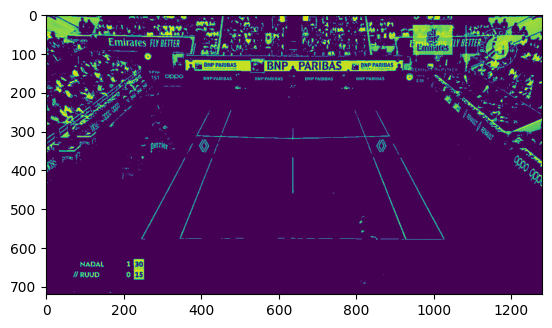

In [893]:
vc_ao.show_frame(img_video)

In [895]:
# Fixed
court_trapezoid = CourtTrapezoid(vc_wb)
h, w = vc_us.h, vc_us.w

y_range_stride = [0, h//2]

# First Evaluation Mask
y_range_mpA = [0, h]
x_range_mpA = [0,w//2]
mpA = np.array([y_range_mpA, x_range_mpA])
img_video = d_neg["rg"]

# ------------------------------------- #

# ------------------------------------- #
#     Optimize first corner
# ------------------------------------- #

# ------------------------------------- #
# Fixed
thickness = 20
scale = 1
a = int(w)
b = int(w)
f = int(h)

# ************************* #
# Generate mesh of strides
# ************************* #
# Start from bottom left in X and Y
x = np.arange(x_range_mpA[0], x_range_mpA[1], thickness)
y = np.arange(y_range_stride[0], y_range_stride[1], thickness)

# Meshgrid based on the thickness of the first attempt line
xv, yv = np.meshgrid(x, y)
xy_mesh = np.array(np.c_[xv.ravel(), yv.ravel()], dtype=int)

# ************************* #
# Generate mesh of trapezoid params
# ************************* #
# Create mesh of trapezoid params
step_size = 0.2
frac_a = np.arange(0.6, 0.9, step_size)
frac_b = np.arange(0.2, 0.5, step_size)
frac_f = np.arange(0.4, 0.6, step_size)
av, bv, fv = np.meshgrid(frac_a, frac_b, frac_f)
abf_mesh = np.array(np.c_[av.ravel(), bv.ravel(), fv.ravel()], dtype=float)

In [896]:
%time
gain_opt = 0
it_stride_optim = 0
img_trapezoid_opt, img_final_opt, img_input_opt, strided_pts_opt = None, None, None, None
for it_stride, (xx, yy) in tqdm.tqdm(enumerate(xy_mesh)):
    
    # Create trapezoid
    stride_pts = (xx,-yy)
    
    # Iterate on the mesh of trapezoid params
    for it_params, (frac_aa, frac_bb, frac_ff) in enumerate(abf_mesh):
        
        it_a = a * frac_aa
        it_b = b * frac_bb
        it_f = b * frac_ff

        # Calculate trapezoid
        img_trapezoid, img_final, img_input, strided_pts = court_trapezoid.create_trapezoid(it_a,it_b,it_f, thickness=thickness, stride=stride_pts, img_input=img_video)

        # Evaluation
        gain = court_trapezoid.compute_gain(img_trapezoid, img_input, mpA)
        #img_trapezoid_pA = img_trapezoid[mpA[0,0]:mpA[0,1], mpA[1,0]:mpA[1,1]]
        #img_input_pA = img_input[mpA[0,0]:mpA[0,1], mpA[1,0]:mpA[1,1]]
        #gain = np.sum(img_trapezoid_pA * img_input_pA)
        if gain > gain_opt:
            it_stride_optim = it_stride
            it_params_optim = it_params
            it_a_optim = it_a
            it_b_optim = it_b
            it_f_optim = it_f
            gain_opt = gain
            img_trapezoid_opt = img_trapezoid
            img_final_opt = img_final
            img_input_opt = img_input
            strided_pts_opt = strided_pts


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs


576it [00:02, 260.53it/s]


In [900]:
np.mean(strided_pts_opt, axis=1)

array([[424., 304.]])

In [902]:
ixx = img_final_opt.copy()
cv2.circle(ixx, [424, 304], 5, (255, 255, 255), 3)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

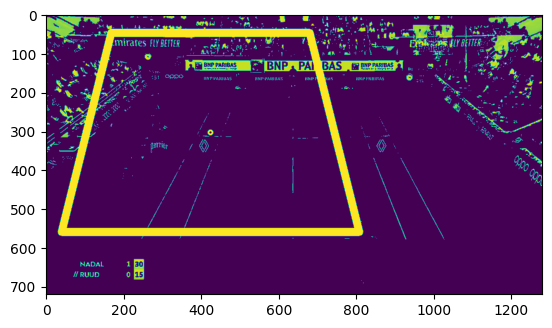

In [903]:
vc_us.show_frame(ixx)

In [708]:
# Create trapezoid
xx, yy = xy_mesh[40]
stride_pts = (xx,-yy)
img_trapezoid, img_final, img_input, strided_pts = court_trapezoid.create_trapezoid(a,b,f,sc=scale, thickness=thickness, stride=stride_pts, img_input=img_video)

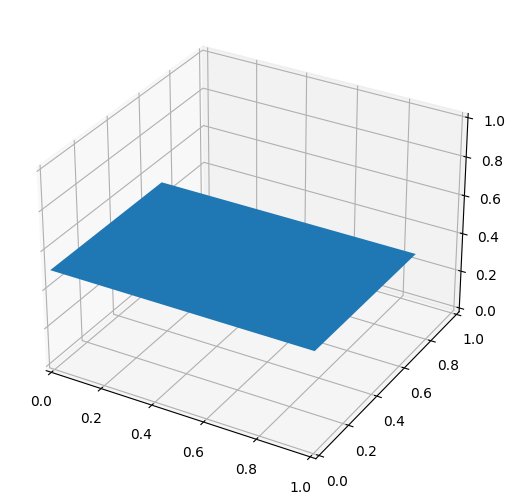

In [446]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)

rect = np.array([[[ 0,  0],
        [ 0,  .7],
        [ 1,  .7],
        [1,  0]]])

fig.add_axes(ax)
x = list(rect[0][:,0])
y = list(rect[0][:,1])
z = [.5,.5,.5,.5]
verts = [list(zip(x,y,z))]
ax.add_collection3d(Poly3DCollection(verts))
plt.show()

In [392]:
np.sum(img_trapezoid * img_input)

81836

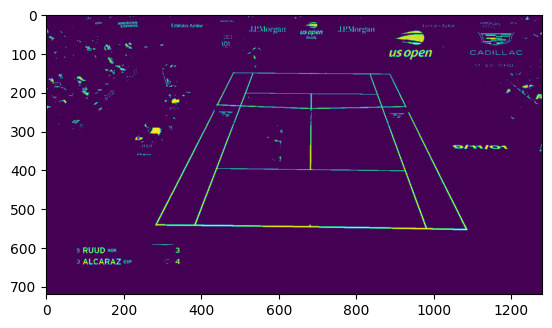

In [357]:
vc_us.show_frame(img_input)

In [263]:
def get_3d_rotation_matrix(width, height, theta, phi, gamma, dx, dy, dz):
    w, h = width, height
    d = np.sqrt(w ** 2 + h ** 2)
    focal = f = d / (2 * np.sin(gamma) if np.sin(gamma) != 0 else 1)
    dz = focal

    # Projection 2D -> 3D matrix
    A1 = np.array([[1, 0, -w / 2],
                   [0, 1, -h / 2],
                   [0, 0, 1],
                   [0, 0, 1]])

    # Rotation matrices around the X, Y, and Z axis
    RX = np.array([[1, 0, 0, 0],
                   [0, np.cos(theta), -np.sin(theta), 0],
                   [0, np.sin(theta), np.cos(theta), 0],
                   [0, 0, 0, 1]])

    RY = np.array([[np.cos(phi), 0, -np.sin(phi), 0],
                   [0, 1, 0, 0],
                   [np.sin(phi), 0, np.cos(phi), 0],
                   [0, 0, 0, 1]])

    RZ = np.array([[np.cos(gamma), -np.sin(gamma), 0, 0],
                   [np.sin(gamma), np.cos(gamma), 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])

    # Composed rotation matrix with (RX, RY, RZ)
    R = np.dot(np.dot(RX, RY), RZ)

    # Translation matrix
    T = np.array([[1, 0, 0, dx],
                  [0, 1, 0, dy],
                  [0, 0, 1, dz],
                  [0, 0, 0, 1]])

    # Projection 3D -> 2D matrix
    A2 = np.array([[f, 0, w / 2, 0],
                   [0, f, h / 2, 0],
                   [0, 0, 1, 0]])

    # Final transformation matrix
    return np.dot(A2, np.dot(T, np.dot(R, A1)))


def get_image_3d_rotated(image, theta, phi, gamma, dx, dy, dz):
    height, width, _ = image.shape
    rtheta, rphi, rgamma = np.deg2rad(theta), np.deg2rad(phi), np.deg2rad(gamma)
    mat = get_3d_rotation_matrix(width, height, rtheta, rphi, rgamma, dx, dy, dz)

    return cv2.warpPerspective(image.copy(), mat, (width, height))


if __name__ == '__main__':
    image = cv2.imread('1.jpg')
    rotated_img = get_image_3d_rotated(image, 15, 16, 17, 0, 0, 0)

Docstring:
rotate(src, rotateCode[, dst]) -> dst
.   @brief Rotates a 2D array in multiples of 90 degrees.
.   The function cv::rotate rotates the array in one of three different ways:
.   *   Rotate by 90 degrees clockwise (rotateCode = ROTATE_90_CLOCKWISE).
.   *   Rotate by 180 degrees clockwise (rotateCode = ROTATE_180).
.   *   Rotate by 270 degrees clockwise (rotateCode = ROTATE_90_COUNTERCLOCKWISE).
.   @param src input array.
.   @param dst output array of the same type as src.  The size is the same with ROTATE_180,
.   and the rows and cols are switched for ROTATE_90_CLOCKWISE and ROTATE_90_COUNTERCLOCKWISE.
.   @param rotateCode an enum to specify how to rotate the array; see the enum #RotateFlags
.   @sa transpose , repeat , completeSymm, flip, RotateFlags
Type:      builtin_function_or_method


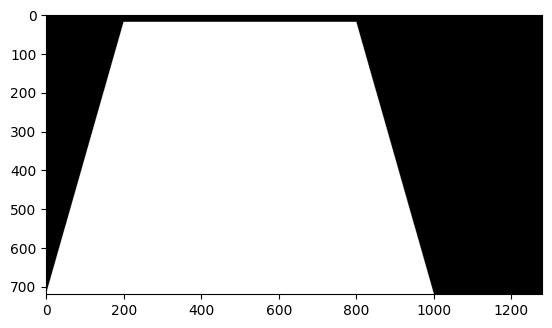

In [396]:
import cv2 as cv
import numpy as np

RED = (255, 255, 255)
pts = [pA, pB, pC, pD]
#pts = [flip(pp) for pp in pts]
#pts = [(0,720), (70, 740), (-70, 800), (100, 720)]

img = np.zeros((VC.h, VC.w, 3), np.uint8)
cv.fillPoly(img, np.array([pts]), RED)
VC.show_frame(img)

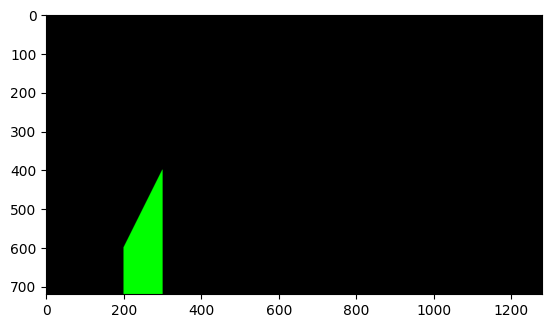

In [200]:
img = np.zeros((VC.h, VC.w, 3), np.uint8)
pts = [(200,600), (300, 400), (300, 800), (200, 800)]
cv.fillPoly(img, np.array([pts]), RED)
VC.show_frame(img)

In [162]:
img.shape

(720, 1280, 3)